# Captcha Bypass

**Team 99**

Pranavbhai Patel

Nicholas Leung

Coden Mercurius

Ravi Singh

**Description**

CAPTCHA, or Completely Automated Public Turing Test to Tell Computers and Humans Apart, is a challenge-response test that determines whether a user is authentic (human) or inauthentic (machine). They require users to authenticate themselves by retyping a character sequence prior to completing a request. This notebook implements a CAPTCHA bypass using deep learning. The team aims to investigate weaknesses and vulnerabilities of the CAPTCHA system.

In [1]:
import torch
import torch.nn as nn
import os
from skimage import io
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import torchvision 
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

## Part 1. Data Processing

The dataset for this model is generated using the following library: https://github.com/lepture/captcha. No additional data augmentation is performed at this time. The code used to generate the dataset is found in the team private repo and is named `dataset_generator.py`.

**Primary Dataset Characteristics:**
- Uniform distribution of characters used
- 36 characters, 0-9 and A-Z
- 3000 captchas

**Secondary Dataset:**
- A dataset of a smaller character space is also availiable
- 10 numerical characters, 0-9
- 1981 captchas


The generated datasets are availiable through the team private repo. Upload `alphanumeric_dataset.zip` or `numeric_dataset.zip` into the root session storage and run the below cells to unzip. Update the path as needed.

In [2]:
dataset_path = "/content/alphanumeric_dataset"

In [3]:
!unzip  /content/alphanumeric_dataset.zip -d /content/

Archive:  /content/alphanumeric_dataset.zip
 extracting: /content/alphanumeric_dataset/007FB.png  
 extracting: /content/alphanumeric_dataset/009YJ.png  
 extracting: /content/alphanumeric_dataset/00R6J.png  
 extracting: /content/alphanumeric_dataset/017IA.png  
 extracting: /content/alphanumeric_dataset/01H2I.png  
 extracting: /content/alphanumeric_dataset/021IO.png  
 extracting: /content/alphanumeric_dataset/02MSD.png  
 extracting: /content/alphanumeric_dataset/038IL.png  
 extracting: /content/alphanumeric_dataset/0448R.png  
 extracting: /content/alphanumeric_dataset/046FD.png  
 extracting: /content/alphanumeric_dataset/04B07.png  
 extracting: /content/alphanumeric_dataset/04UDL.png  
 extracting: /content/alphanumeric_dataset/04XMB.png  
 extracting: /content/alphanumeric_dataset/06CDT.png  
 extracting: /content/alphanumeric_dataset/06DU6.png  
 extracting: /content/alphanumeric_dataset/06Y3O.png  
 extracting: /content/alphanumeric_dataset/07DA5.png  
 extracting: /content

In [4]:
class CaptchaDataset(Dataset):
  """ Captcha Dataset """

  def __init__(self, directory):
    self.directory = directory
    self.captchas = os.listdir(directory)
    self.captchas.remove("metadata.txt")

    self.transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    self.character_set = open(directory + "/metadata.txt", "r").readline().split(',')
    self.characters_to_identifier = {}

    for i in range(len(self.character_set)):
      self.characters_to_identifier.update({ self.character_set[i]: i })

  def __len__(self):
    # Assumes each file in the dataset directory represents a data sample
    return len(self.captchas)

  def __getitem__(self, index):
    sample_name = self.captchas[index]
    sample_captcha_values = list(sample_name[0:-4]) # Slice s.t. remove png file extension

    # Read the image and represent it as a tensor
    image = io.imread(self.directory + '/' + sample_name)
    image = self.transform(image)

    # Represent each character as an integer identifier
    label = []
    for char in sample_captcha_values:
      label.append(self.characters_to_identifier.get(char))

    return (image, torch.tensor(label))

In [5]:
# Instantiate dataset
dataset = CaptchaDataset(dataset_path)
character_set = dataset.character_set

character_frequency = {} # Contains frequency information

# Populate character_frequency
for _, label in dataset:
  for char_identifier in label:
    char = character_set[char_identifier.item()]
    current_value = character_frequency.get(char, None)

    if current_value is None: 
      character_frequency.update({ char : 0 })
    else:
      character_frequency.update({ char : current_value + 1 })

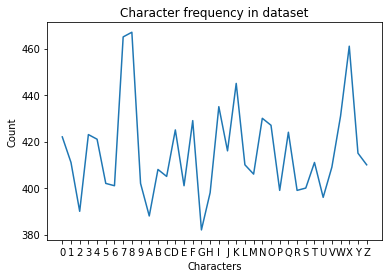

In [6]:
# Dataset visualization

x_values = range(len(character_set))
y_values = []

for char in character_set:
  count = character_frequency.get(char)
  y_values.append(count)

plt.title("Character frequency in dataset")
plt.plot(x_values, y_values)
plt.xlabel("Characters")
plt.ylabel("Count")
plt.xticks(x_values, character_set)
plt.show()


In [7]:
def get_data_loaders(dataset, batch_size):

  training_ratio = 0.7
  validation_ratio = 0.15
  # test_ratio implied

  train_length = int(len(dataset) * training_ratio)
  validation_length = int((len(dataset) - train_length) * (validation_ratio / ( 1 - training_ratio )))
  test_length = len(dataset) - train_length - validation_length
  
  train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [train_length, validation_length, test_length], torch.Generator().manual_seed(10))

  # REMINDER: Data is not shuffled per epoch, we may want this
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
  valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, num_workers=1)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

  return train_loader, valid_loader, test_loader


## Part 2. Captcha Segmentation

This module performs captcha segmentation which is leveraged in the final captcha solver product. Using OpenCV Contour recognition, a given captcha image is segmented into its individual characters.


In [8]:
import random
import cv2
import torchvision as tv

In [9]:
def processimage(image, thresh):
      #Format image type/ dimensions
      image=image.permute(1,2,0)
      image=image.numpy()
      imageorig=image
      
      #Modify image so contours/ borders can be easily found
      #Greyscale
      image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      #Binary Threshold
      NA, image = cv2.threshold(image, thresh, 1, cv2.THRESH_BINARY)
      #Erosion
      kernel = np.ones((2,2),np.uint8)
      image = cv2.dilate(image,kernel,iterations = 1)
      #Vertical Blur and Resharpen
      morpher = cv2.getStructuringElement(cv2.MORPH_RECT, (1,3))
      image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, morpher)
      #Binary Threshold  
      thresh, image = cv2.threshold(image,thresh, 1, cv2.THRESH_BINARY)
      #Expand Border
      image=cv2.copyMakeBorder(image, 5, 5, 5, 5,cv2.BORDER_CONSTANT,value=1)
      image = image.astype(np.uint8)

      return imageorig,image

In [10]:
def segmentimage(image,narrow):
    #Return list of borderlines in image
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #imagecont=cv2.drawContours(image, contours, -1, (0, 0.5, 0), 1)

    #Creates boxes for every large object
    boxes=[]
    for contour in contours:
        [x,y,w,h]=cv2.boundingRect(contour)
        if(w>8 and w<120 and h>30):
          boxes.append([x,y,w,h])
    boxes.sort(key=lambda x: x[0])

    #Eliminates boxes that are contained whithin other boxes (subparts of a letter)
    i=1
    while (i<len(boxes)):
      box=boxes[i]
      boxprev=boxes[i-1]
      if (box[0]>boxprev[0] and box[1]>boxprev[1] and (box[0]+box[2])<(boxprev[0]+boxprev[2]) and (box[1]+box[3])<(boxprev[1]+boxprev[3])):
        boxes.pop(i)
        i-=1
      i+=1

    #If boxes are too wide they may contain multiple boxes 
    #They are split vertically into 2 or 3 subboxes (even width splits)
    i=0
    while (i<len(boxes)):
      box=boxes[i]
      if (box[2]>box[3]*(0.95-narrow)):
        x,y,w,h=boxes.pop(i)
        boxes.insert(i,[x+int((2*w)/3),y,int(w/3),h])
        boxes.insert(i,[x+int((w)/3),y,int(w/3),h])
        boxes.insert(i,[x,y,int(w/3),h])
      elif (box[2]>box[3]*(0.6-narrow)):
        x,y,w,h=boxes.pop(i)
        boxes.insert(i,[x+int(w/2),y,int(w/2),h])
        boxes.insert(i,[x,y,int(w/2),h])
      if (i>=len(boxes)-1):
        break
      i+=1
    
    return boxes


    


In [11]:
def getcharacterimages(images, showsegments=False, filterBadSegmentation=False):
  characters=[]
  for i in range (0,len(images)):
    imageraw = images[i]
 
    # CAPTCHA image pre-processed, custom function called
    # Rectangle Borders of each character obtained, custom function called
    for i in range(0,7):
      thresh, narrow = 0.6,0
      if (i>=1):
        narrow=0.1
        thresh=0.6+(i-1)*0.1
      imageorig, image=processimage(imageraw,thresh)
      imageboxes = np.copy(image)
      boxes=segmentimage(image,narrow)
      if (len(boxes)>=5):
        break

    # Filter bad segmentation cases
    if filterBadSegmentation and len(boxes) < 5:
      continue
      
    # Individual Characters images are cut out from CAPTCHA image
    charactersset=[]
    for i in range(0,5):
      # If insufficient letters obtainable, add an empty image
      if (i<len(boxes)):
        box=boxes[i]
      else:
        box=[0,0,1,1]

      [x,y,w,h]=box
      char=image[y:y+h,x:x+w]
      height=char.shape[0]
      width=char.shape[1]
      # cv2.copyMakeBorder(soruce, top, bottom, left, right, borderType, value)
      if (width>height):
        char=cv2.copyMakeBorder(char, int ((width-height)/2),int ((width-height)/2), 0, 0,cv2.BORDER_CONSTANT,value=1)
      if (height>width):
        char=cv2.copyMakeBorder(char,0,0, int ((height-width)/2), int ((height-width)/2),cv2.BORDER_CONSTANT,value=1)
      char = cv2.resize(char, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
      char=torch.Tensor(char)
      charactersset.append(char)
      cv2.rectangle(imageboxes,(x,y),(x+w,y+h),0,1)
    charactersset=torch.stack(charactersset)
    characters.append(charactersset)
    
    if (showsegments==True):
      plt.imshow(imageorig)
      plt.show()
      plt.imshow(imageboxes, cmap='gray', vmin = 0, vmax = 1)
      plt.show()
      for i in range(0,5):
        plt.subplot(1,5,i+1)
        plt.imshow(charactersset[i], cmap='gray', vmin = 0, vmax = 1)
      plt.show()

  return torch.stack(characters)
  

In [12]:
"""
How To Use - getcharacterimages(images, showsegments=False)

Input = tensor(batchsize,numchannels,height,width) (see below)
Output = tensor(batchsize, numcharacters = 5, height = 80, width = 80 )

Turn showsegments on to visualize segmentation process
"""
train, valid, test = get_data_loaders(dataset, 100)

images_processed = 0
successful_segmentation = 0

for images, labels in train:
  characters = getcharacterimages(images, False, True)
  images_processed = images_processed + len(labels)
  successful_segmentation = successful_segmentation + len(characters)

print(f"Successful segmentation accuracy: { successful_segmentation / images_processed }")

Successful segmentation accuracy: 0.9652380952380952


## Part 3. Base Model

The base model for our captcha solver is a completely non-deep learning method. The model consists of a module for segmentation and a module for individual character classification, similar to the primary model. For segmentation, we use the OpenCV Contours implementation previously defined. For classification of individual characters, we use SVM. 

In [13]:
from sklearn import svm
import numpy as np

In [14]:
class BaseModel:

  def __init__(self):
    self.classifier = svm.SVC()

  def fit_classifier(self, dataloader):

    # Preprocessing to make our PyTorch data in acceptable format

    input_acc = []
    labels_acc = []

    for images, labels in dataloader:

      segmented_captchas = getcharacterimages(images)

      # Iterate over each captcha
      for i in range(len(segmented_captchas)):
        captcha = segmented_captchas[i]
        
        # Iterate over each character
        for j in range(len(captcha)):
          input_acc.append(captcha[j].detach().numpy().reshape(-1))
          labels_acc.append(labels[i][j].detach().numpy())
    
    input_acc = np.array(input_acc)
    labels_acc = np.array(labels_acc)

    # Train character classification

    self.classifier.fit(input_acc, labels_acc)

  def predict(self, images):
    segmented_captchas = getcharacterimages(images)

    output = []
    for captcha in segmented_captchas:

      out_captcha = []

      for character in captcha:
        numpy_char = character.detach().numpy().reshape((1, -1)) # Reshape to acceptable input for SVM predict()
        out_char = self.classifier.predict(numpy_char)
        out_captcha.append(out_char.item())
      
      output.append(out_captcha)

    return torch.tensor(output)


### Model Fitting

The model is fitted on the training set. The "learnable" portion of the model is the character classifier which learns based off of the segmented characters.

In [15]:
model = BaseModel()
train, valid, test = get_data_loaders(dataset, 100)

model.fit_classifier(train)

### Model Performance

The base model can be used for prediction by calling model.predict(input). The input is a mini-batch defined as a tensor. Internally, the model will convert the tensor format to a format SVM accepts.

In [16]:
def evaluate_base_model(dataloader):

  total_character_guesses = 0
  total_captcha_guesses = 0

  incorrect_character_guesses = 0
  incorrect_captcha_guesses = 0

  failed_guess_frequency = {}

  for images, labels in dataloader:
    out = model.predict(images)

    # Iterate through each sample captcha in batch
    for i in range(len(labels)):
      bad_guess = False

      # Iterate through each character of captcha
      for j in range(len(labels[i])):

        total_character_guesses = total_character_guesses + 1
        guess = out[i][j]
        expected = labels[i][j]

        if (guess != expected):
          incorrect_character_guesses = incorrect_character_guesses + 1

          # Track per character bad guesses
          current_failed_guess_count = failed_guess_frequency.get(dataset.character_set[guess], 0)
          failed_guess_frequency.update({ dataset.character_set[guess]: current_failed_guess_count + 1 })

          bad_guess = True
      
      if bad_guess:
        incorrect_captcha_guesses = incorrect_captcha_guesses + 1
      
      total_captcha_guesses = total_captcha_guesses + 1

  # Overall accuracy information

  character_guess_accuracy = (total_character_guesses - incorrect_character_guesses) / total_character_guesses
  captcha_guess_accuracy = (total_captcha_guesses - incorrect_captcha_guesses) / total_captcha_guesses
  
  print(f"Character Guess Accuracy: {character_guess_accuracy}")
  print(f"Captcha Guess Accuracy: {captcha_guess_accuracy}")

  # Plot incorrect character guess frequency

  bad_guess_character_set = failed_guess_frequency.keys()

  x_values = range(len(bad_guess_character_set))
  y_values = []

  for char in bad_guess_character_set:
    count = failed_guess_frequency.get(char)
    y_values.append(count)

  plt.title("Bad guess character frequency")
  plt.plot(x_values, y_values)
  plt.xlabel("Characters")
  plt.ylabel("Count")
  plt.xticks(x_values, bad_guess_character_set)
  plt.show()



Base Model Performance on Validation Set
Character Guess Accuracy: 0.8048997772828508
Captcha Guess Accuracy: 0.5100222717149221


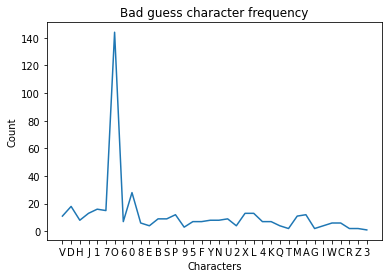

In [17]:
print("Base Model Performance on Validation Set")
acc = evaluate_base_model(valid)